In [1]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
# Load preprocessed data from Notebooks: 1,2,3,5,6,8 
df = pd.read_csv("TMDB_tv_dataset_v3.csv")


In [5]:
# Missing Values
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
columns_to_fill = [col for col in categorical_cols if col != 'genres']
df[columns_to_fill] = df[columns_to_fill].apply(lambda col: col.fillna(col.mode()[0]))

# Remove duplicates
df = df.drop_duplicates()

#One Hot Encoding
df['genres'] = df['genres'].fillna('Unknown') # for genres that are empty just call them Unknown

df['genres'] = df['genres'].apply(lambda x: x.split(', '))

unique_genres = sorted(set(genre for genres in df['genres'] for genre in genres))

for genre in unique_genres:
  df[genre] = df['genres'].apply(lambda genres: int(genre in genres))

df = df.drop('genres', axis=1)

df.to_csv('TMDB_tv_dataset_v3.csv', index=False)

list = df.select_dtypes(include=['object']).columns.tolist()
encode_cols =['original_language','type', 'status','created_by','networks','origin_country','production_companies']

# Creating one-hot encoded columns for original_language
top_20_original_language = df['original_language'].value_counts(ascending = False).head(20).index.tolist()
for i in top_20_original_language:
    name = 'original-language_' + i
    df[name] = np.where(df['original_language'] == i, 1, 0)

# Removing the original_language column from df and encode_cols
df.drop(columns = ['original_language'], inplace = True)
encode_cols.remove('original_language')
df.columns

# Creating a list of the top 10 values in the created_by column
top_10_created_by = df['created_by'].value_counts(ascending = False).head(10).index.tolist()
# Creating one-hot encoded columns for created_by
for i in top_10_created_by:
    name = 'created-by_' + i
    df[name] = np.where(df['created_by'] == i, 1, 0)

# Removing the created_by column from df and encode_cols
df.drop(columns = ['created_by'], inplace = True)
encode_cols.remove('created_by')

# Creating a list of the top 11 values in the networks column
top_11_networks = df['networks'].value_counts(ascending = False).head(11).index.tolist()

# Creating one-hot encoded columns for networks
for i in top_11_networks:
    name = 'networks_' + i
    df[name] = np.where(df['networks'] == i, 1, 0)

# Removing the networks column from df and encode_cols
df.drop(columns = ['networks'], inplace = True)
encode_cols.remove('networks')

# Creating a list of the top 10 values in the origin_country column
top_26_origin_country = df['origin_country'].value_counts(ascending = False).head(26).index.tolist()

one_hot_encoded_origin_country = pd.DataFrame() # start with an empty dataframe

for i in top_26_origin_country:
    one_hot_encoded_origin_country['origin-country_' + i] = np.where(df['origin_country'] == i, 1, 0)

# the we can concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, one_hot_encoded_origin_country], axis=1)

# Removing the origin_country column from df and encode_cols
df.drop(columns = ['origin_country'], inplace = True)
encode_cols.remove('origin_country')

# Creating a list of the top 10 values in the production_companies column
top_10_production_companies = df['production_companies'].value_counts(ascending = False).head(10).index.tolist()

one_hot_encoded_production_companies = pd.DataFrame() # start with an empty dataframe

for i in top_26_origin_country:
    one_hot_encoded_production_companies['production-companies_' + i] = np.where(df['production_companies'] == i, 1, 0)

# the we can concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, one_hot_encoded_production_companies], axis=1)

# Removing the production_companies column from df and encode_cols
df.drop(columns = ['production_companies'], inplace = True)
encode_cols.remove('production_companies')

# One-hot encoding remaining columns
for colname in encode_cols:
    df_encoded = pd.get_dummies(df[colname], prefix=colname+'')
    df = df.join(df_encoded)

# Removing remaining original cols from df
df.drop(columns=encode_cols,axis=1,inplace=True)


In [6]:
# Converting first_air_date and last_air_date columns to DateTime referring to https://www.youtube.com/watch?v=f7LODKIjtaA
df['first_air_date'] = pd.to_datetime(df['first_air_date'], format = '%Y-%m-%d')
df['last_air_date'] = pd.to_datetime(df['last_air_date'], format = '%Y-%m-%d' )
print(df['first_air_date'].dtypes)
print(df['last_air_date'].dtypes)

# Creating a function to create seasons for each month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'WINTER'
    elif month in [3, 4, 5]:
        return 'SPRING'
    elif month in [6, 7, 8]:
        return 'SUMMER'
    elif month in [9, 10, 11]:
        return 'FALL'
    else:
        return 'UNKNOWN'
    
# Creating a column with the seasons for first_air_date
df['first_air_date_season'] = df['first_air_date'].apply(get_season)
df['first_air_date_season']

# Creating columns for first_air_date_season as boolean values
df['first_air_date_winter'] = df['first_air_date_season'] == 'WINTER'
df['first_air_date_spring'] = df['first_air_date_season'] == 'SPRING'
df['first_air_date_summer'] = df['first_air_date_season'] == 'SUMMER'
df['first_air_date_fall'] = df['first_air_date_season'] == 'FALL'

# Repeating same process for last_air_date
df['last_air_date_season'] = df['last_air_date'].apply(get_season)
df['last_air_date_season']


datetime64[ns]
datetime64[ns]


/var/folders/0c/2849ld6n7nl3ds4y08tlktqr0000gn/T/ipykernel_93420/3851158569.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['first_air_date_season'] = df['first_air_date'].apply(get_season)
/var/folders/0c/2849ld6n7nl3ds4y08tlktqr0000gn/T/ipykernel_93420/3851158569.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['first_air_date_winter'] = df['first_air_date_season'] == 'WINTER'
/var/folders/0c/2849ld6n7nl3ds4y08tlktqr0000gn/T/ipykernel_93420/3851158569.py:27: PerformanceWarning: DataFrame is highly fragmented.  T

0          SPRING
1          WINTER
2          SUMMER
3            FALL
4            FALL
           ...   
168412    UNKNOWN
168416    UNKNOWN
168418    UNKNOWN
168419    UNKNOWN
168420    UNKNOWN
Name: last_air_date_season, Length: 168593, dtype: object

In [8]:
# Converting first_air_date and last_air_date columns to DateTime referring to https://www.youtube.com/watch?v=f7LODKIjtaA
df['first_air_date'] = pd.to_datetime(df['first_air_date'], format = '%Y-%m-%d')
df['last_air_date'] = pd.to_datetime(df['last_air_date'], format = '%Y-%m-%d' )
print(df['first_air_date'].dtypes)
print(df['last_air_date'].dtypes)

# Creating a function to create seasons for each month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'WINTER'
    elif month in [3, 4, 5]:
        return 'SPRING'
    elif month in [6, 7, 8]:
        return 'SUMMER'
    elif month in [9, 10, 11]:
        return 'FALL'
    else:
        return 'UNKNOWN'
    
# Creating a column with the seasons for first_air_date
df['first_air_date_season'] = df['first_air_date'].apply(get_season)
df['first_air_date_season']

# Creating columns for first_air_date_season as boolean values
df['first_air_date_winter'] = df['first_air_date_season'] == 'WINTER'
df['first_air_date_spring'] = df['first_air_date_season'] == 'SPRING'
df['first_air_date_summer'] = df['first_air_date_season'] == 'SUMMER'
df['first_air_date_fall'] = df['first_air_date_season'] == 'FALL'

# Repeating same process for last_air_date
df['last_air_date_season'] = df['last_air_date'].apply(get_season)
df['last_air_date_season']


datetime64[ns]
datetime64[ns]


0          SPRING
1          WINTER
2          SUMMER
3            FALL
4            FALL
           ...   
168412    UNKNOWN
168416    UNKNOWN
168418    UNKNOWN
168419    UNKNOWN
168420    UNKNOWN
Name: last_air_date_season, Length: 168593, dtype: object

In [9]:
#XGBoost expects numerical values (int, float, bool) for training, so any non-numeric columns need to be encoded or removed.
#original_language, type, status (One-Hot Encoding)


# List of original numerical columns
numerical_columns = ['number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'popularity', 'episode_run_time']

# Apply log transformation and rename columns with "_log"
df_log = df[numerical_columns].apply(lambda x: np.log1p(x)).add_suffix('_log')

# Concatenate the log-transformed columns with the original DataFrame
df = pd.concat([df, df_log], axis=1)

# Display the DataFrame to confirm new columns
print(df.head())

# List of log-transformed numerical columns
numerical_columns_log = [col + '_log' for col in numerical_columns]

# Display summary statistics for log-transformed columns
print(df[numerical_columns_log].describe())



        id              name  number_of_seasons  number_of_episodes  \
0   1399.0   Game of Thrones                8.0                73.0   
1  71446.0       Money Heist                3.0                41.0   
2  66732.0   Stranger Things                4.0                34.0   
3   1402.0  The Walking Dead               11.0               177.0   
4  63174.0           Lucifer                6.0                93.0   

   vote_count  vote_average  \
0     21857.0         8.442   
1     17836.0         8.257   
2     16161.0         8.624   
3     15432.0         8.121   
4     13870.0         8.486   

                                            overview  adult  \
0  Seven noble families fight for control of the ...  False   
1  To carry out the biggest heist in history, a m...  False   
2  When a young boy vanishes, a small town uncove...  False   
3  Sheriff's deputy Rick Grimes awakens from a co...  False   
4  Bored and unhappy as the Lord of Hell, Lucifer...  False   

       

In [10]:
# Winsorize
from scipy.stats.mstats import winsorize

# Define the limits for Winsorization
lower_limit = 0.05  # 5th percentile
upper_limit = 0.95  # 95th percentile

# Winsorize each numerical column and add it back to the DataFrame
for col in numerical_columns:
    df[col + '_winsorized'] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

# Winsorize each log-transformed numerical column and add it back to the DataFrame
for col in numerical_columns_log:
    df[col + '_winsorized'] = winsorize(df[col], limits=(lower_limit, 1 - upper_limit))

In [11]:
# Normalize
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling and add columns with '_norm' suffix to the DataFrame
df[[col + '_norm' for col in numeric_columns]] = scaler.fit_transform(df[numeric_columns])

# Display the updated DataFrame to confirm new normalized columns
print(df.head())

        id              name  number_of_seasons  number_of_episodes  \
0   1399.0   Game of Thrones                8.0                73.0   
1  71446.0       Money Heist                3.0                41.0   
2  66732.0   Stranger Things                4.0                34.0   
3   1402.0  The Walking Dead               11.0               177.0   
4  63174.0           Lucifer                6.0                93.0   

   vote_count  vote_average  \
0     21857.0         8.442   
1     17836.0         8.257   
2     16161.0         8.624   
3     15432.0         8.121   
4     13870.0         8.486   

                                            overview  adult  \
0  Seven noble families fight for control of the ...  False   
1  To carry out the biggest heist in history, a m...  False   
2  When a young boy vanishes, a small town uncove...  False   
3  Sheriff's deputy Rick Grimes awakens from a co...  False   
4  Bored and unhappy as the Lord of Hell, Lucifer...  False   

       

/var/folders/0c/2849ld6n7nl3ds4y08tlktqr0000gn/T/ipykernel_93420/3659227612.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[col + '_norm' for col in numeric_columns]] = scaler.fit_transform(df[numeric_columns])
/var/folders/0c/2849ld6n7nl3ds4y08tlktqr0000gn/T/ipykernel_93420/3659227612.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[col + '_norm' for col in numeric_columns]] = scaler.fit_transform(df[numeric_columns])
/var/folders/0c/2849ld6n7nl3ds4y08tlktqr0000gn/T/ipykernel_93420/3659227612.py:11: Performance

In [9]:

# #overview (Text Vectorization)


# # FOR OVERVIEW COLUMN 
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Apply TF-IDF
# tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Adjust `max_features` as needed
# overview_tfidf = tfidf_vectorizer.fit_transform(X['overview'].fillna('')).toarray()

# # Create a DataFrame from TF-IDF features and merge it
# overview_tfidf_df = pd.DataFrame(overview_tfidf, columns=tfidf_vectorizer.get_feature_names_out())
# X = pd.concat([X.reset_index(drop=True), overview_tfidf_df.reset_index(drop=True)], axis=1)

# # Drop the original 'overview' column
# X = X.drop('overview', axis=1)



In [10]:
#created_by, networks, origin_country, production_companies (Top-N One-Hot Encoding)
#For columns with many unique values, focus on the top N most frequent categories to avoid excessive dimensionality.

# Select top N most frequent categories for each column
top_n = 10
for col in ['created_by', 'networks', 'origin_country', 'production_companies']:
    top_categories = X[col].value_counts().head(top_n).index
    for category in top_categories:
        X[f'{col}_{category}'] = (X[col] == category).astype(int)
    X = X.drop(col, axis=1)  # Drop original column



In [ ]:
#Split the Data
#Split the data into training and testing sets to evaluate the model’s performance.


from sklearn.model_selection import train_test_split
import xgboost as xgb

# Define target (y) and features (X)
y = df["popularity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_regressor = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_regressor.fit(X_train, y_train)



In [11]:
#handle missing values, if any are left:
X = X.fillna(0)  # Replace NaN with 0 for numeric features


In [12]:
print(X.dtypes)


number_of_seasons                                 int64
number_of_episodes                                int64
vote_count                                        int64
vote_average                                    float64
adult                                              bool
                                                 ...   
production_companies_TV 2                         int64
production_companies_Televisa                     int64
production_companies_Česká televize               int64
production_companies_GMA Entertainment Group      int64
production_companies_ATV Enterprises Limited      int64
Length: 662, dtype: object


In [13]:
#Split the data into training and test sets:

from sklearn.model_selection import train_test_split

y = df["popularity"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
#Train the XGBoost model on the prepared dataset:
import xgboost as xgb

model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
#Evaluate our model using metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE):
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


Mean Absolute Error: 5.26
Root Mean Squared Error: 37.51


In [16]:
#Verifying performance: 

print(f"Min popularity: {y.min()}, Max popularity: {y.max()}")



Min popularity: 0.0, Max popularity: 3707.008


## Analysis: 

MAE of 5.26: On average, the predictions are off by 5.26 popularity units, which is 0.14% of the range. This is very low, indicating strong model performance.
RMSE of 37.51: The RMSE, while larger, is still only about 1% of the range, meaning the model penalizes some large deviations but overall performs well.


In [17]:
# Calculate Relative Performance (Baseline Comparison)
baseline_pred = [y_train.mean()] * len(y_test)  # Always predict the mean of the training set
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = mean_squared_error(y_test, baseline_pred, squared=False)

print(f"Baseline Mean Absolute Error: {baseline_mae:.2f}")
print(f"Baseline Root Mean Squared Error: {baseline_rmse:.2f}")


Baseline Mean Absolute Error: 7.90
Baseline Root Mean Squared Error: 37.55


## Conclusion: 
Good MAE: Our model is better than the baseline in predicting the average popularity, showing clear value.
Similar RMSE: There might still be some predictions with large errors. These could be caused by outliers or noise in the dataset.

## Next Steps...
1. Investigate Outliers (in popularity)
2. Use Robust Metrics for Model Evaluation - Since RMSE is sensitive to outliers, consider using metrics like Median Absolute Error (MedAE)
3. Hyperparameter Tuning? 
4. Feature Engineering ? 

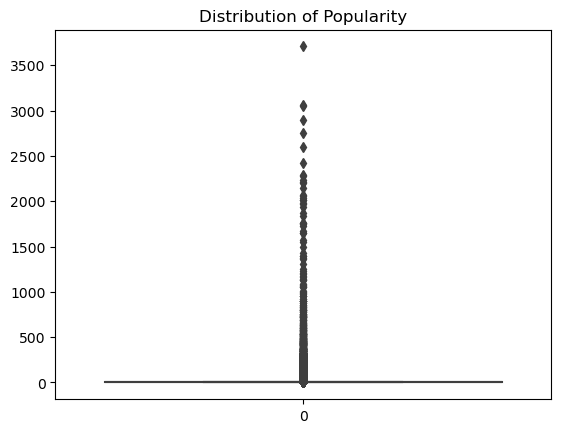

In [19]:
#Next Steps:
# 1. Investigate Outliers -> 
# Transform the target variable (e.g., log transformation).
# Cap or remove extreme values.


import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(y)
plt.title("Distribution of Popularity")
plt.show()


In [21]:
#2. Median Absolute Error 

from sklearn.metrics import median_absolute_error

medae = median_absolute_error(y_test, y_pred)
print(f"Median Absolute Error: {medae:.2f}")


Median Absolute Error: 0.77


## Strong Median Performance:

With MedAE = 0.77, the typical prediction is off by less than 1 unit, which is excellent relative to your popularity range (0.0 to 3707.008).
Possible Presence of Outliers:

Since RMSE (37.51) is significantly higher than MedAE (0.77), this suggests some large prediction errors (outliers) are increasing the RMSE.




In [22]:
# Calculate absolute errors
errors = abs(y_test - y_pred)

# Identify largest errors
large_errors = errors[errors > errors.median() * 2]
print("Number of large errors:", len(large_errors))


Number of large errors: 11076


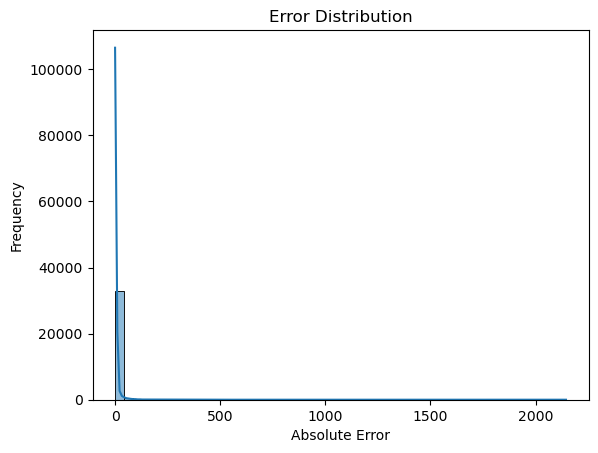

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate absolute errors
errors = abs(y_test - y_pred)

# Visualize error distribution
sns.histplot(errors, bins=50, kde=True)
plt.title("Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.show()


In [24]:
# Identify rows with errors > 2000
extreme_errors = errors[errors > 2000]
print(f"Number of extreme errors: {len(extreme_errors)}")

# Examine the data for these rows
extreme_error_rows = X_test.loc[extreme_errors.index]
print(extreme_error_rows.head())


Number of extreme errors: 3
       number_of_seasons  number_of_episodes  vote_count  vote_average  adult  \
94781                  1                  30           0         0.000  False   
94057                  1                  30           0         0.000  False   
7217                   1                2107          23         4.565  False   

       episode_run_time  original_language_ab  original_language_af  \
94781                 0                     0                     0   
94057                 0                     0                     0   
7217                 22                     0                     0   

       original_language_am  original_language_ar  ...  \
94781                     0                     1  ...   
94057                     0                     1  ...   
7217                      0                     0  ...   

       production_companies_TVB  production_companies_BBC  \
94781                         0                         0   
94057  

## Potential Issues:

1. Missing or Zero Values:
Zero values for vote_count, vote_average, and episode_run_time might confuse the model, as these features are important predictors for popularity.

2. Outlier in number_of_episodes:
Row 7217 has an unusually high number_of_episodes (2107), which might be an error or a very rare case.